# Import libraries and mount drive

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!rm DeconvModels.py
!rm training_functions.py
!rm blur_functions.py
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Models/DeconvModels.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/training_functions.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/blur_functions.py -q
from DeconvModels import Deconv2D
from training_functions import train_regression_model, train_classification_model
import blur_functions as blur

rm: cannot remove 'DeconvModels.py': No such file or directory
rm: cannot remove 'training_functions.py': No such file or directory
rm: cannot remove 'blur_functions.py': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/data/kaggle-sir/'

Mounted at /content/drive


# Dataset Class and create dataloader

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, ds_path):
        self.ds_path = ds_path

        y_imgs = os.listdir(f'{ds_path}/HR')[:20]


        self.y_paths = list(map(lambda img_path: f'{ds_path}/HR/{img_path}', y_imgs))
        self.x_paths = list(map(lambda img_path: f'{ds_path}/LR/{img_path}', y_imgs))

    
    def __len__(self):
        return len(self.y_paths)


    def __getitem__(self, idx):
        y_path = self.y_paths[idx]
        x_path = self.x_paths[idx]

        # x_img = io.read_image(x_path, io.ImageReadMode.GRAY)
        y_img = io.read_image(y_path, io.ImageReadMode.GRAY)
        x_img = io.read_image(x_path, io.ImageReadMode.GRAY)

        SIZE = 384
        PAD_SIZE = SIZE//8

        # Preprocess image
        y_img = T.Resize((SIZE, SIZE))(y_img)
        y_img = y_img / 255.0
        y_img = nn.functional.pad(y_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        # Preprocess image
        x_img = T.Resize((SIZE, SIZE))(x_img)
        x_img = x_img / 255.0
        x_img = nn.functional.pad(x_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        return x_img, y_img

In [ ]:
data = ImageDataset(base_path)
dataloader = DataLoader(data, batch_size=8, shuffle=False)

x_batch, y_batch = next(iter(dataloader))

x_batch.size(), y_batch.size()

(torch.Size([8, 1, 480, 480]), torch.Size([8, 1, 480, 480]))

(-0.5, 479.5, 479.5, -0.5)

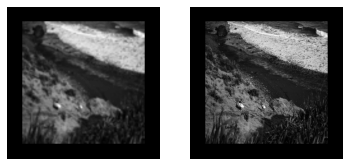

In [ ]:
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(x_batch[0, 0, :, :], cmap='gray')
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(y_batch[0, 0, :, :], cmap='gray')
plt.axis(False)

# Initialise Model, Criterion, Optimizer

In [ ]:
model = Deconv2D((6, 6))

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
history, _ = train_regression_model(model, criterion, optimizer, dataloader, num_epochs=200)

Epoch 0001 loss: 0.01150
Epoch 0011 loss: 0.00904
Epoch 0021 loss: 0.00875
Epoch 0031 loss: 0.00863
Epoch 0041 loss: 0.00857
Epoch 0051 loss: 0.00854
Epoch 0061 loss: 0.00851
Epoch 0071 loss: 0.00848
Epoch 0081 loss: 0.00845
Epoch 0091 loss: 0.00842
Epoch 0101 loss: 0.00838
Epoch 0111 loss: 0.00835
Epoch 0121 loss: 0.00831
Epoch 0131 loss: 0.00827
Epoch 0141 loss: 0.00824
Epoch 0151 loss: 0.00820
Epoch 0161 loss: 0.00817
Epoch 0171 loss: 0.00813
Epoch 0181 loss: 0.00810
Epoch 0191 loss: 0.00808


Text(0.5, 1.0, 'Original')

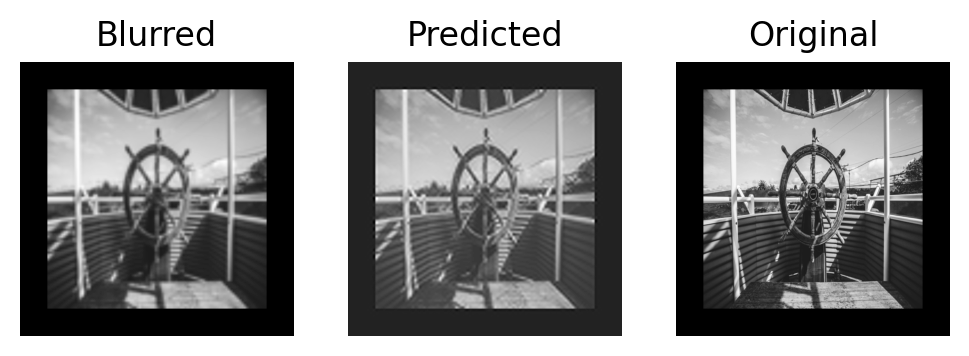

In [ ]:
model = model.to("cpu")
model.eval()
X, y = next(iter(dataloader))

y_pred = model(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,0,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Original')